In [1]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_18/259814137.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


I am following the Deep Learning course of Mike X Cohen on Udemy, Lecture 48 Exercise on Learning Rates and how they affect the accuracy and losses

👩🏻‍🚀 To understand the effect of learning rate, we will contruct some parametric experiments 

👩🏻‍🚀 When we far away from the  minimum point, we need larger learning rates - but when we get close to the minimum point, we need smaller learning rates not to pass the minimum, we need aproach slowly

In [2]:
# Data and fized parameters
# Create Data
nPerClust = 100
blur = 1

#
A = [ 1,1]
B = [ 5,1]

# generate data
# add some noise to the data with std:blur
# so that there can be a distribution with a center indicated above
a = [ A[0] + np.random.randn(nPerClust)*blur , A[1] + np.random.randn(nPerClust)*blur]
b = [ B[0] + np.random.randn(nPerClust)*blur , B[1] + np.random.randn(nPerClust)*blur]

# concat them into one data matrix
data_np = np.hstack((a,b)).T

# true labels
labels_np = np.vstack(( np.zeros((nPerClust,1)) , np.ones((nPerClust,1)) ))

# convert to pytorch tensor - probably np library has more functions to construct and reshape data?
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# ANN params
epochNo = 1000

In [3]:
# Functions First
# 1- Create Model
def buildANNModel(learning_rate):

  ANNClassify = nn.Sequential(
      nn.Linear(2,1),
      nn.ReLU(),
      nn.Linear(1,1),
      # nn.Sigmoid(1,1) # lets use PyTorch sigmoid itself
  )

  # loss function
  # Binary Cross Entropy Loss problem - recommended function from PyTorch
  lossfun = nn.BCEWithLogitsLoss()
  # optimizer
  # SGD: stochasitc gradient
  # other possible optimizers: adam, rmsProp etc
  optimizer = torch.optim.SGD(ANNClassify.parameters(), lr=learning_rate)

  return ANNClassify, optimizer, lossfun


# 2- Train and Test the model
def trainTestModel(ANNClassify, optimizer, lossfun): # my definition
# def trainTestModel(ANNClassify): #mike's definition
  losses = torch.zeros(epochNo)

  for epochi in range(epochNo):
    # forward pass
    yHat = ANNClassify(data)

    # loss function
    loss = lossfun(yHat, labels)
    losses[epochi] = loss

    # bakcprop
    optimizer.zero_grad()
    loss.backward() # backprop depend on the loss, need to optimize Weights depend on the loss
    optimizer.step()

  # test the model - final forward pass
  predictions = ANNClassify(data)

  # calculate accuracy
  # NOTE: shouldn't this be 0.5 instead of 0?
  # Because we use the internal Sigmoid function in BCEWithLogitsLoss()
  # so we are not using the result of Sigmoid function explicitly
  totalacc = 100*torch.mean(((predictions>0)==labels).float())

  return losses, predictions, totalacc

Final accuracy: 50%


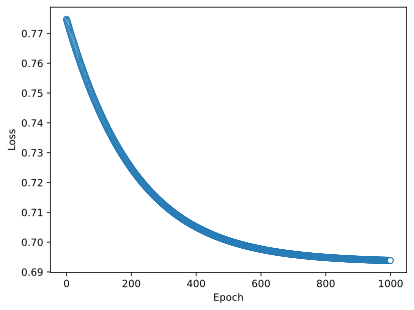

In [4]:
# Test the code
# Build the model
ANNClassify, optimizer, lossfun = buildANNModel(.01)
# Train and test it
# my definition of function with 3 parameters
losses, predictions, totalacc = trainTestModel(ANNClassify, optimizer, lossfun)
# mike's definition of function
# losses, predictions, totalacc = trainTestModel(ANNClassify)

# Report the accuracy
print('Final accuracy: %g%%' %totalacc)

# Show the losses
plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=.1)
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

In [5]:
# Now the experiment of Learning Rate
# The set of Lr to test
learning_rates = np.linspace(0.001, 0.1, 40)

# initialize results output
accuractByLR = []
allLosses = np.zeros((len(learning_rates), epochNo))

for lri in range(len(learning_rates)):
  # create and run the model
  ANNClassify, optimizer, lossfun = buildANNModel(learning_rates[lri])
  # train and test
  # my definition of function with 3 parameters
  losses, predictions, totalacc = trainTestModel(ANNClassify, optimizer, lossfun)

  accuractByLR.append(totalacc)
  allLosses[lri,:] = losses.detach() # turn into np

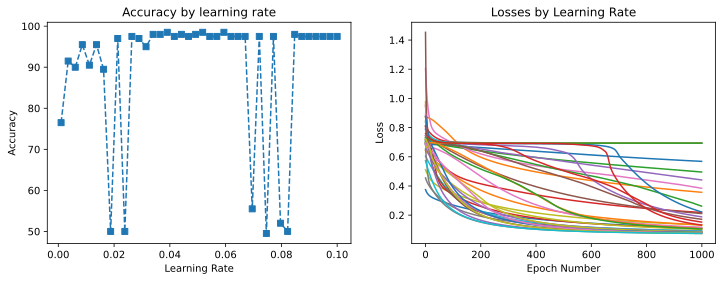

In [6]:
# Plotting
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(learning_rates, accuractByLR, 's--')
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T)
ax[1].set_xlabel('Epoch Number')
ax[1].set_ylabel('Loss')
ax[1].set_title('Losses by Learning Rate')

plt.show()

According to figures, the accuracy pinpointing between %50 and %100 suggesting that sometimes model learns nothing and blindly guessing (chance level) - but sometimes the model gets lucky with initial weights randomization and gives good results near the %100

In the loss figure, the different LRs can decrease the loss until one point and then they stuch at there 

In [7]:
# proportion of runs where the model has at least 70% accuracy
sum(torch.tensor(accuractByLR)>70)/len(accuractByLR)

tensor(0.8500)